<a href="https://colab.research.google.com/github/mlvlab/data303/blob/main/Image_Generation_by_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generative Adversarial Networks (GANs)
======

This example is derived from 1. 'Deep Learning for Graphics Tutorial'.

Resources:

1.  CreativeAI: Deep Learning for Graphics Tutorial [[Link]](https://github.com/smartgeometry-ucl/dl4g)
2.  debuggercafe.com [[Link]](https://debuggercafe.com/vanilla-gan-pytorch/)

In [1]:
%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib

from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

matplotlib.style.use('ggplot')

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

import os
os.chdir('/content/drive/MyDrive/data303/gan')
print(os.getcwd())

Mounted at /content/drive/
/content/drive/MyDrive/data303/gan


## 1. Learn a GAN (deconv) with 64x64

### Hyperparameters


In [ ]:
latent_dims = 256
num_epochs = 40
batch_size = 512
learning_rate = 2e-4
use_gpu = True

### MNIST Data Loading

MNIST images show digits from 0-9 in 28x28 grayscale images. We scale to 64x64 so we can have a deeper architecture with more down-sampling steps. The images are normalized and centerd around 0, which gives a slight performance boost during training. We create both a training set and a test set.



In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
def count_param(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### GAN Architecture
Like DCGAN, we use CNNs for generator and discriminator, which generally outperform vanilla GANs with fully connected layers.

In [ ]:
class Generator(nn.Module):
    def __init__(self, d=128):
        super(Generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(latent_dims, d*8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 1, 4, 2, 1)

    def forward(self, input):
        # x = F.relu(self.deconv1(input))
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = torch.tanh(self.deconv5(x))

        return x

class Discriminator(nn.Module):
    def __init__(self, d=128):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0)

    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.conv5(x))

        return x
    
generator = Generator()
discriminator = Discriminator()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
print(device)

generator = generator.to(device)
discriminator = discriminator.to(device)

num_params_gen = count_param(generator)
num_params_disc = count_param(discriminator)
print('Number of parameters for generator: {:,} and discriminator: {:,}'.format(num_params_gen, num_params_disc))

cuda:0
Number of parameters for generator: 15,212,161 and discriminator: 11,033,985


In [ ]:
# GAN training can be unstable. In this case, the strong momentum
# for the gradient prevents convergence. One possible explanation is that the
# strong momentum does not allow the two players in the adversarial game to react
# to each other quickly enough. Decreasing beta1 (the exponential decay for the
# gradient moving average in [0,1], lower is faster decay) from the default 0.9
# to 0.5 allows for quicker reactions.
gen_optimizer = torch.optim.Adam(params=generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# set to training mode
generator.train()
discriminator.train()

gen_loss_avg = []
disc_loss_avg = []
gen_images = [] # to store images generated by the generator by epoch
sample_size = 100
num_grid = 10

gen_latent = torch.randn(sample_size, latent_dims, 1, 1, device=device)

print('Training ...')

for epoch in range(num_epochs):

    gen_loss_avg.append(0)
    disc_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in train_dataloader:
        
        # get dataset image and create real and fake labels for use in the loss
        image_batch = image_batch.to(device)
        label_real = torch.ones(image_batch.size(0), device=device)
        label_fake = torch.zeros(image_batch.size(0), device=device)

        # generate a batch of images from samples of the latent prior
        latent = torch.randn(image_batch.size(0), latent_dims, 1, 1, device=device)
        fake_image_batch = generator(latent)

        # train discriminator to correctly classify real and fake
        # (detach the computation graph of the generator and the discriminator,
        # so that gradients are not backpropagated into the generator)
        real_pred = discriminator(image_batch).squeeze()
        fake_pred = discriminator(fake_image_batch.detach()).squeeze()
        disc_loss = 0.5 * (
            F.binary_cross_entropy(real_pred, label_real) +
            F.binary_cross_entropy(fake_pred, label_fake))
        
        disc_optimizer.zero_grad()
        disc_loss.backward()
        disc_optimizer.step()
        
        # train generator to output an image that is classified as real
        fake_pred = discriminator(fake_image_batch).squeeze()
        gen_loss = F.binary_cross_entropy(fake_pred, label_real)
        
        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()
        
        gen_loss_avg[-1] += gen_loss.item()
        disc_loss_avg[-1] += disc_loss.item()
        num_batches += 1
            
    # create the final fake image for the epoch
    generated_img = generator(gen_latent).cpu().detach()
    generated_img = make_grid(generated_img, nrow = num_grid)
    save_image(generated_img, f"/content/drive/MyDrive/data303/gan/outputs/gen_img_{learning_rate}_{batch_size}_{latent_dims}_{epoch}.png")
    gen_images.append(generated_img)

    gen_loss_avg[-1] /= num_batches
    disc_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average loss generator vs. discrim.: %f vs. %f' %
          (epoch+1, num_epochs, gen_loss_avg[-1], disc_loss_avg[-1]))

Training ...
Epoch [1 / 40] average loss generator vs. discrim.: 8.269758 vs. 0.047482
Epoch [2 / 40] average loss generator vs. discrim.: 8.941906 vs. 0.096396
Epoch [3 / 40] average loss generator vs. discrim.: 8.764678 vs. 0.224819
Epoch [4 / 40] average loss generator vs. discrim.: 6.378299 vs. 0.004291
Epoch [5 / 40] average loss generator vs. discrim.: 5.478988 vs. 0.313256
Epoch [6 / 40] average loss generator vs. discrim.: 2.255740 vs. 0.494846
Epoch [7 / 40] average loss generator vs. discrim.: 1.818244 vs. 0.534831
Epoch [8 / 40] average loss generator vs. discrim.: 1.451760 vs. 0.559357
Epoch [9 / 40] average loss generator vs. discrim.: 1.269429 vs. 0.558905
Epoch [10 / 40] average loss generator vs. discrim.: 1.456544 vs. 0.542896
Epoch [11 / 40] average loss generator vs. discrim.: 2.038047 vs. 0.508160
Epoch [12 / 40] average loss generator vs. discrim.: 2.044760 vs. 0.446471
Epoch [13 / 40] average loss generator vs. discrim.: 6.699968 vs. 0.090109
Epoch [14 / 40] avera

In [ ]:
to_pil_image = transforms.ToPILImage()
imgs = [np.array(to_pil_image(img)) for img in gen_images]
imageio.mimwrite(f'/content/drive/MyDrive/data303/gan/outputs/gen_img_{learning_rate}_{batch_size}_{latent_dims}.gif', imgs, duration=0.5)

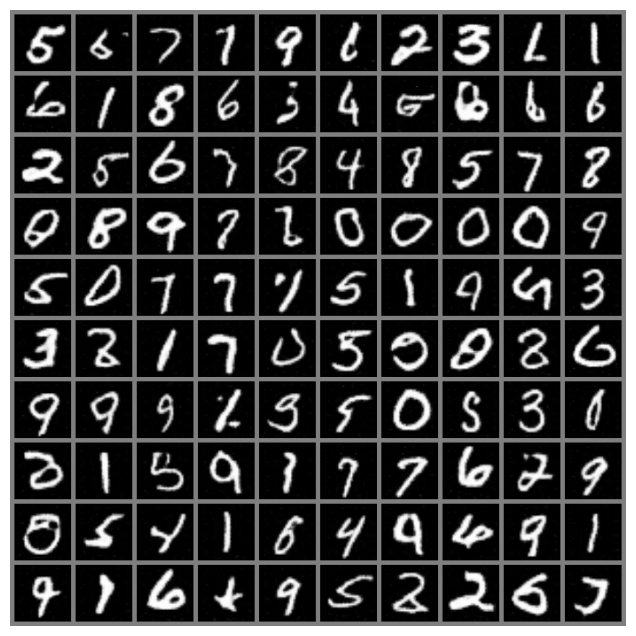

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

with torch.no_grad():

    # sample latent vectors from the standard normal distribution
    latent = torch.randn(sample_size, latent_dims, 1, 1, device=device)
    fake_image_batch = generator(latent)
    fake_image_batch = fake_image_batch.cpu()

    fig, ax = plt.subplots(figsize=(8, 8))
    show_image(make_grid(fake_image_batch.data[:100], 10, 5))
    ax.axis('off')
    plt.savefig(f'/content/drive/MyDrive/data303/gan/outputs/result_{learning_rate}_{batch_size}_{latent_dims}.png')
    plt.show()


### Plot Training Curves

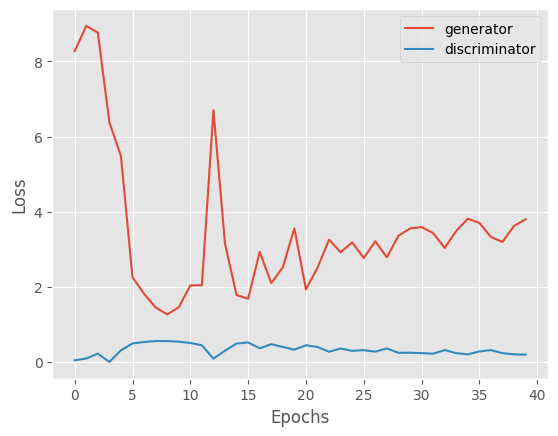

In [ ]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(gen_loss_avg, label='generator')
plt.plot(disc_loss_avg, label='discriminator')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'/content/drive/MyDrive/data303/gan/outputs/loss_{learning_rate}_{batch_size}_{latent_dims}.png')
plt.show()

In [ ]:
# Save Models   
torch.save(generator.state_dict(), f'/content/drive/MyDrive/data303/gan/models/exp1-generator_{learning_rate}_{batch_size}_{latent_dims}.pth')
torch.save(discriminator.state_dict(),f'/content/drive/MyDrive/data303/gan/models/exp1-discriminator_{learning_rate}_{batch_size}_{latent_dims}.pth')

### Interpolate in Latent Space

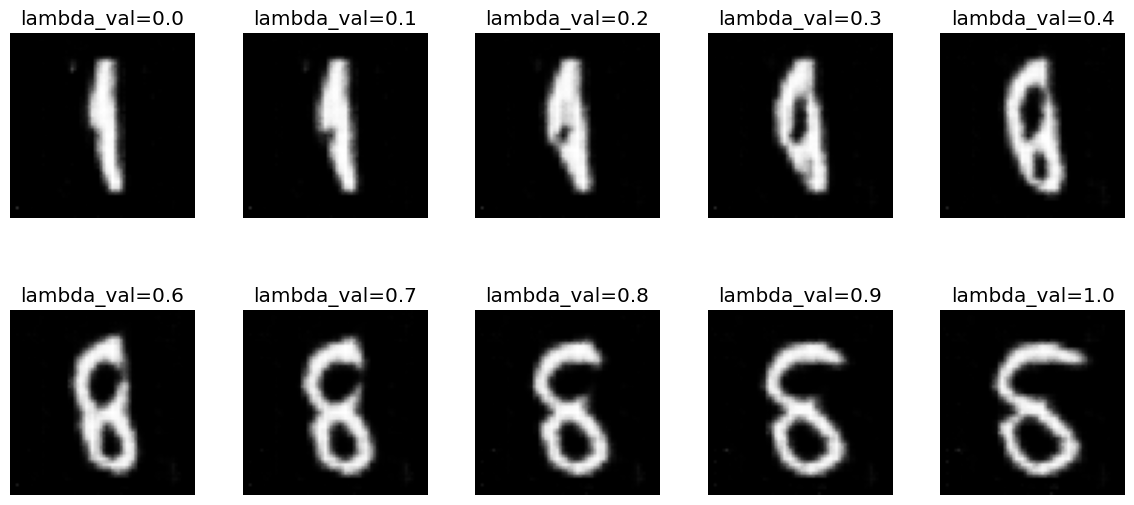

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator = Generator()
generator.load_state_dict(torch.load('/content/drive/MyDrive/data303/gan/models/exp1-generator_0.0002_512_256.pth'))
generator = generator.to(device)

generator.eval()

def interpolation(lambda1, model, latent_1, latent_2):

    with torch.no_grad():

        # interpolation of the two latent vectors
        inter_latent = lambda1 * latent_1 + (1 - lambda1) * latent_2

        # reconstruct interpolated image
        inter_latent = inter_latent.to(device)
        inter_image = model(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image

# sample two latent vectors from the standard normal distribution
latent_1 = torch.randn(1, latent_dims, 1, 1, device=device)
latent_2 = torch.randn(1, latent_dims, 1, 1, device=device)

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image = interpolation(float(l), generator, latent_1, latent_2)
   
    inter_image = to_img(inter_image)
    
    image = inter_image.numpy()
   
    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
    axs[ind].axis('off')

plt.show() 

## 2. Learn a GAN (deconv) with 28x28

### Hyperparameters


In [ ]:
latent_dims = 64
num_epochs = 40
batch_size = 512
learning_rate = 2e-4
use_gpu = True

### MNIST Data Loading




In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
def count_param(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### GAN Architecture
Like DCGAN, we use CNNs for generator and discriminator, which generally outperform vanilla GANs with fully connected layers.

In [ ]:
class Generator(nn.Module):
    def __init__(self, d=128):
        super(Generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(latent_dims, d*4, 4, 1, 0) # 1x1 => 4x4
        self.deconv1_bn = nn.BatchNorm2d(d*4)
        self.deconv2 = nn.ConvTranspose2d(d*4, d*2, 4, 1, 0) # 4x4 => 7x7
        self.deconv2_bn = nn.BatchNorm2d(d*2)
        self.deconv3 = nn.ConvTranspose2d(d*2, d, 4, 2, 1) # 7x7 => 14x14
        self.deconv3_bn = nn.BatchNorm2d(d)
        self.deconv4 = nn.ConvTranspose2d(d, 1, 4, 2, 1) # 14x14 => 28x28

    def forward(self, input):
        # x = F.relu(self.deconv1(input))
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = torch.tanh(self.deconv4(x))

        return x

class Discriminator(nn.Module):
    def __init__(self, d=128):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 1, 0)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, 1, 4, 1, 0)

    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = torch.sigmoid(self.conv4(x))

        return x
    
generator = Generator()
discriminator = Discriminator()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
print(device)

generator = generator.to(device)
discriminator = discriminator.to(device)

num_params_gen = count_param(generator)
num_params_disc = count_param(discriminator)
print('Number of parameters for generator: {:,} and discriminator: {:,}'.format(num_params_gen, num_params_disc))

cuda:0
Number of parameters for generator: 3,150,465 and discriminator: 2,634,113


In [ ]:
# GAN training can be unstable. In this case, the strong momentum
# for the gradient prevents convergence. One possible explanation is that the
# strong momentum does not allow the two players in the adversarial game to react
# to each other quickly enough. Decreasing beta1 (the exponential decay for the
# gradient moving average in [0,1], lower is faster decay) from the default 0.9
# to 0.5 allows for quicker reactions.
gen_optimizer = torch.optim.Adam(params=generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# set to training mode
generator.train()
discriminator.train()

gen_loss_avg = []
disc_loss_avg = []
gen_images = [] # to store images generated by the generator by epoch
sample_size = 100
num_grid = 10

gen_latent = torch.randn(sample_size, latent_dims, 1, 1, device=device)

print('Training ...')

for epoch in range(num_epochs):

    gen_loss_avg.append(0)
    disc_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in train_dataloader:
        
        # get dataset image and create real and fake labels for use in the loss
        image_batch = image_batch.to(device)
        label_real = torch.ones(image_batch.size(0), device=device)
        label_fake = torch.zeros(image_batch.size(0), device=device)

        # generate a batch of images from samples of the latent prior
        latent = torch.randn(image_batch.size(0), latent_dims, 1, 1, device=device)
        fake_image_batch = generator(latent)

        # train discriminator to correctly classify real and fake
        # (detach the computation graph of the generator and the discriminator,
        # so that gradients are not backpropagated into the generator)
        real_pred = discriminator(image_batch).squeeze()
        fake_pred = discriminator(fake_image_batch.detach()).squeeze()
        disc_loss = 0.5 * (
            F.binary_cross_entropy(real_pred, label_real) +
            F.binary_cross_entropy(fake_pred, label_fake))
        
        disc_optimizer.zero_grad()
        disc_loss.backward()
        disc_optimizer.step()
        
        # train generator to output an image that is classified as real
        fake_pred = discriminator(fake_image_batch).squeeze()
        gen_loss = F.binary_cross_entropy(fake_pred, label_real)
        
        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()
        
        gen_loss_avg[-1] += gen_loss.item()
        disc_loss_avg[-1] += disc_loss.item()
        num_batches += 1
            
    # create the final fake image for the epoch
    generated_img = generator(gen_latent).cpu().detach()
    generated_img = make_grid(generated_img, nrow = num_grid)
    save_image(generated_img, f"/content/drive/MyDrive/data303/gan/outputs/exp2_gen_img_{learning_rate}_{batch_size}_{latent_dims}_{epoch}.png")
    gen_images.append(generated_img)

    gen_loss_avg[-1] /= num_batches
    disc_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average loss generator vs. discrim.: %f vs. %f' %
          (epoch+1, num_epochs, gen_loss_avg[-1], disc_loss_avg[-1]))

Training ...
Epoch [1 / 40] average loss generator vs. discrim.: 6.672596 vs. 0.121924
Epoch [2 / 40] average loss generator vs. discrim.: 8.614621 vs. 0.038961
Epoch [3 / 40] average loss generator vs. discrim.: 7.530041 vs. 0.037444
Epoch [4 / 40] average loss generator vs. discrim.: 4.839375 vs. 0.215249
Epoch [5 / 40] average loss generator vs. discrim.: 3.955891 vs. 0.341855
Epoch [6 / 40] average loss generator vs. discrim.: 2.917453 vs. 0.363375
Epoch [7 / 40] average loss generator vs. discrim.: 2.080077 vs. 0.425617
Epoch [8 / 40] average loss generator vs. discrim.: 1.634572 vs. 0.462461
Epoch [9 / 40] average loss generator vs. discrim.: 1.683789 vs. 0.457280
Epoch [10 / 40] average loss generator vs. discrim.: 1.702418 vs. 0.452993
Epoch [11 / 40] average loss generator vs. discrim.: 1.526955 vs. 0.476032
Epoch [12 / 40] average loss generator vs. discrim.: 1.581044 vs. 0.452120
Epoch [13 / 40] average loss generator vs. discrim.: 1.617709 vs. 0.417371
Epoch [14 / 40] avera

In [ ]:
to_pil_image = transforms.ToPILImage()
imgs = [np.array(to_pil_image(img)) for img in gen_images]
imageio.mimwrite(f'/content/drive/MyDrive/data303/gan/outputs/exp2_gen_img_{learning_rate}_{batch_size}_{latent_dims}.gif', imgs, duration=0.5)

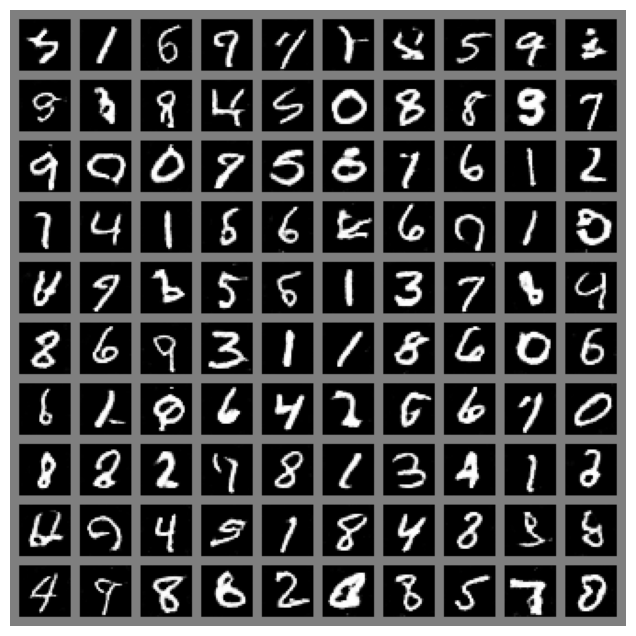

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

with torch.no_grad():

    # sample latent vectors from the standard normal distribution
    latent = torch.randn(sample_size, latent_dims, 1, 1, device=device)
    fake_image_batch = generator(latent)
    fake_image_batch = fake_image_batch.cpu()

    fig, ax = plt.subplots(figsize=(8, 8))
    show_image(make_grid(fake_image_batch.data[:100], 10, 5))
    ax.axis('off')
    plt.savefig(f'/content/drive/MyDrive/data303/gan/outputs/exp2_result_{learning_rate}_{batch_size}_{latent_dims}.png')
    plt.show()


### Plot Training Curves

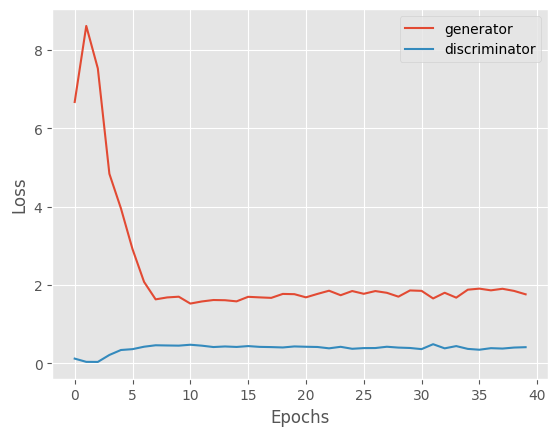

In [ ]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(gen_loss_avg, label='generator')
plt.plot(disc_loss_avg, label='discriminator')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'/content/drive/MyDrive/data303/gan/outputs/exp2_loss_{learning_rate}_{batch_size}_{latent_dims}.png')
plt.show()

In [ ]:
# Save Models   
torch.save(generator.state_dict(), f'/content/drive/MyDrive/data303/gan/models/exp2-generator_{learning_rate}_{batch_size}_{latent_dims}.pth')
torch.save(discriminator.state_dict(),f'/content/drive/MyDrive/data303/gan/models/exp2-discriminator_{learning_rate}_{batch_size}_{latent_dims}.pth')

### Interpolate in Latent Space

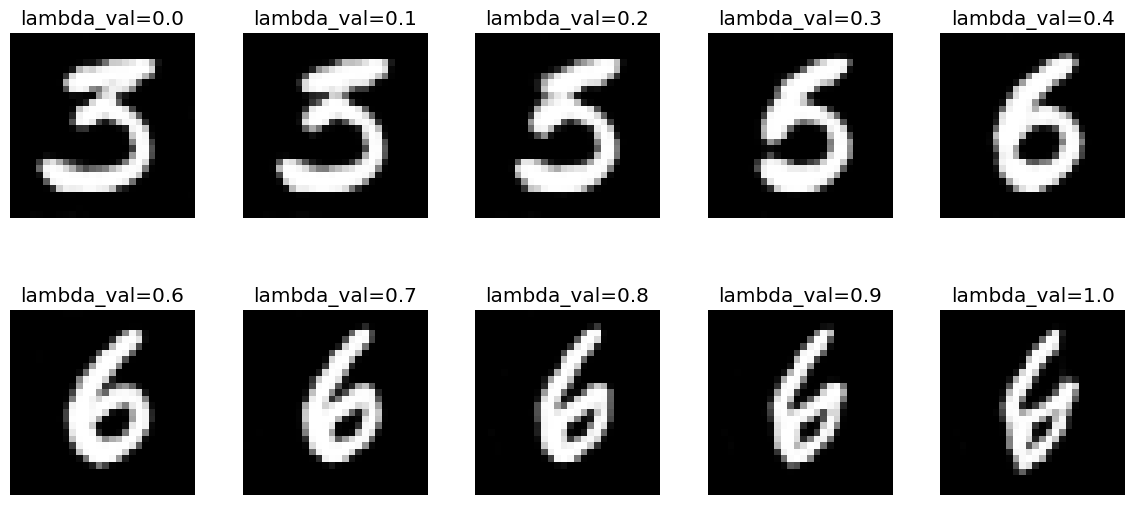

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator = Generator()
generator.load_state_dict(torch.load('/content/drive/MyDrive/data303/gan/models/exp2-generator_0.0002_512_64.pth'))
generator = generator.to(device)

generator.eval()

def interpolation(lambda1, model, latent_1, latent_2):

    with torch.no_grad():

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_latent = inter_latent.to(device)
        inter_image = model(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image
    
# sample two latent vectors from the standard normal distribution
latent_1 = torch.randn(1, latent_dims, 1, 1, device=device)
latent_2 = torch.randn(1, latent_dims, 1, 1, device=device)

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image = interpolation(float(l), generator, latent_1, latent_2)
   
    inter_image = to_img(inter_image)
    
    image = inter_image.numpy()
   
    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
    axs[ind].axis('off')
    
plt.show() 

## 3. Learn a GAN (MLP)

### Hyperparameters


In [ ]:
latent_dims = 100
num_epochs = 100
batch_size = 128
learning_rate = 2e-4
use_gpu = True

### MNIST Data Loading (28x28)




In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
def count_param(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### GAN Architecture

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(latent_dims, latent_dims*2)
        self.fc2 = nn.Linear(latent_dims*2, latent_dims*4)
        self.fc3 = nn.Linear(latent_dims*4, latent_dims*8)
        self.fc4 = nn.Linear(latent_dims*8, 28*28)

    def forward(self, input):
        x = F.leaky_relu(self.fc1(input), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = torch.tanh(self.fc4(x))
        x = x.view(-1, 1, 28, 28)
        
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_dims*8)
        self.fc2 = nn.Linear(latent_dims*8, latent_dims*4)
        self.fc3 = nn.Linear(latent_dims*4, latent_dims*2)
        self.fc4 = nn.Linear(latent_dims*2, 1)

    def forward(self, input):
        x = input.view(-1, 28*28)
        x = F.dropout(F.leaky_relu(self.fc1(x), 0.2), 0.3)
        x = F.dropout(F.leaky_relu(self.fc2(x), 0.2), 0.3)
        x = F.dropout(F.leaky_relu(self.fc3(x), 0.2), 0.3)
        x = torch.sigmoid(self.fc4(x))

        return x
    
generator = Generator()
discriminator = Discriminator()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
print(device)

generator = generator.to(device)
discriminator = discriminator.to(device)

num_params_gen = count_param(generator)
num_params_disc = count_param(discriminator)
print('Number of parameters for generator: {:,} and discriminator: {:,}'.format(num_params_gen, num_params_disc))

cuda:0
Number of parameters for generator: 1,049,384 and discriminator: 1,028,801


In [ ]:
# GAN training can be unstable. In this case, the strong momentum
# for the gradient prevents convergence. One possible explanation is that the
# strong momentum does not allow the two players in the adversarial game to react
# to each other quickly enough. Decreasing beta1 (the exponential decay for the
# gradient moving average in [0,1], lower is faster decay) from the default 0.9
# to 0.5 allows for quicker reactions.
gen_optimizer = torch.optim.Adam(params=generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# set to training mode
generator.train()
discriminator.train()

gen_loss_avg = []
disc_loss_avg = []
gen_images = [] # to store images generated by the generator by epoch
sample_size = 100
num_grid = 10

gen_latent = torch.randn(sample_size, latent_dims, device=device)

print('Training ...')

for epoch in range(num_epochs):

    gen_loss_avg.append(0)
    disc_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in train_dataloader:
        
        # get dataset image and create real and fake labels for use in the loss
        image_batch = image_batch.to(device)
        label_real = torch.ones(image_batch.size(0), device=device)
        label_fake = torch.zeros(image_batch.size(0), device=device)

        # generate a batch of images from samples of the latent prior
        latent = torch.randn(image_batch.size(0), latent_dims, device=device)
        fake_image_batch = generator(latent)

        # train discriminator to correctly classify real and fake
        # (detach the computation graph of the generator and the discriminator,
        # so that gradients are not backpropagated into the generator)
        real_pred = discriminator(image_batch).squeeze()
        fake_pred = discriminator(fake_image_batch.detach()).squeeze()
        disc_loss = 0.5 * (
            F.binary_cross_entropy(real_pred, label_real) +
            F.binary_cross_entropy(fake_pred, label_fake))
        
        disc_optimizer.zero_grad()
        disc_loss.backward()
        disc_optimizer.step()
        
        # train generator to output an image that is classified as real
        fake_pred = discriminator(fake_image_batch).squeeze()
        gen_loss = F.binary_cross_entropy(fake_pred, label_real)
        
        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()
        
        gen_loss_avg[-1] += gen_loss.item()
        disc_loss_avg[-1] += disc_loss.item()
        num_batches += 1
            
    # create the final fake image for the epoch
    generated_img = generator(gen_latent).cpu().detach()
    generated_img = make_grid(generated_img, nrow = num_grid)
    save_image(generated_img, f"/content/drive/MyDrive/data303/gan/outputs/exp3_gen_img_{learning_rate}_{batch_size}_{latent_dims}_{epoch}.png")
    gen_images.append(generated_img)

    gen_loss_avg[-1] /= num_batches
    disc_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average loss generator vs. discrim.: %f vs. %f' %
          (epoch+1, num_epochs, gen_loss_avg[-1], disc_loss_avg[-1]))

Training ...
Epoch [1 / 100] average loss generator vs. discrim.: 3.953027 vs. 0.234284
Epoch [2 / 100] average loss generator vs. discrim.: 3.452740 vs. 0.235385
Epoch [3 / 100] average loss generator vs. discrim.: 3.763175 vs. 0.191292
Epoch [4 / 100] average loss generator vs. discrim.: 3.399287 vs. 0.170795
Epoch [5 / 100] average loss generator vs. discrim.: 2.917733 vs. 0.191316
Epoch [6 / 100] average loss generator vs. discrim.: 2.484520 vs. 0.261827
Epoch [7 / 100] average loss generator vs. discrim.: 2.243693 vs. 0.290724
Epoch [8 / 100] average loss generator vs. discrim.: 2.194809 vs. 0.301020
Epoch [9 / 100] average loss generator vs. discrim.: 2.045721 vs. 0.340205
Epoch [10 / 100] average loss generator vs. discrim.: 1.862577 vs. 0.370418
Epoch [11 / 100] average loss generator vs. discrim.: 1.728514 vs. 0.399766
Epoch [12 / 100] average loss generator vs. discrim.: 1.640319 vs. 0.429214
Epoch [13 / 100] average loss generator vs. discrim.: 1.645677 vs. 0.426880
Epoch [1

In [ ]:
to_pil_image = transforms.ToPILImage()
imgs = [np.array(to_pil_image(img)) for img in gen_images]
imageio.mimwrite(f'/content/drive/MyDrive/data303/gan/outputs/exp3_gen_img_{learning_rate}_{batch_size}_{latent_dims}.gif', imgs, duration=0.5)

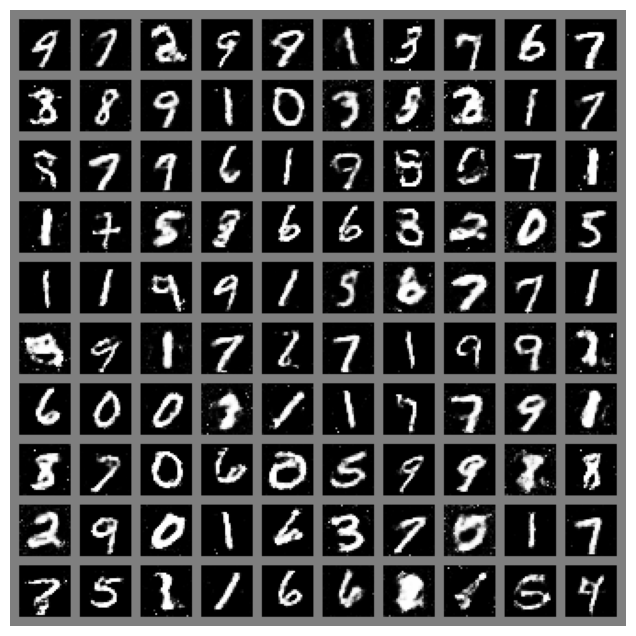

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

with torch.no_grad():

    # sample latent vectors from the standard normal distribution
    latent = torch.randn(sample_size, latent_dims, device=device)
    fake_image_batch = generator(latent)
    fake_image_batch = fake_image_batch.cpu()

    fig, ax = plt.subplots(figsize=(8, 8))
    show_image(make_grid(fake_image_batch.data[:100], 10, 5))
    ax.axis('off')
    plt.savefig(f'/content/drive/MyDrive/data303/gan/outputs/exp3_result_{learning_rate}_{batch_size}_{latent_dims}.png')
    plt.show()


### Plot Training Curves

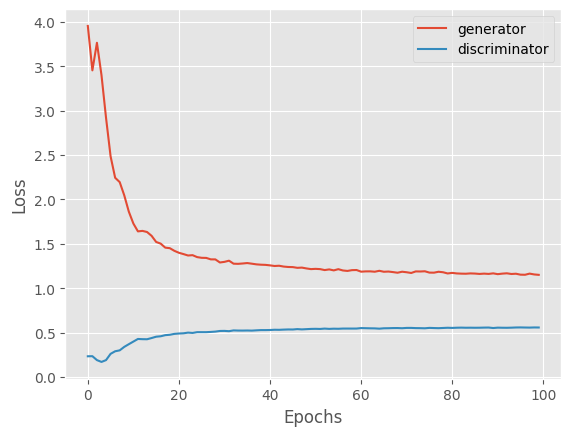

In [ ]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(gen_loss_avg, label='generator')
plt.plot(disc_loss_avg, label='discriminator')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'/content/drive/MyDrive/data303/gan/outputs/exp3_loss_{learning_rate}_{batch_size}_{latent_dims}.png')
plt.show()

In [ ]:
# Save Models   
torch.save(generator.state_dict(), f'/content/drive/MyDrive/data303/gan/models/exp3-generator_{learning_rate}_{batch_size}_{latent_dims}.pth')
torch.save(discriminator.state_dict(),f'/content/drive/MyDrive/data303/gan/models/exp3-discriminator_{learning_rate}_{batch_size}_{latent_dims}.pth')

### Interpolate in Latent Space

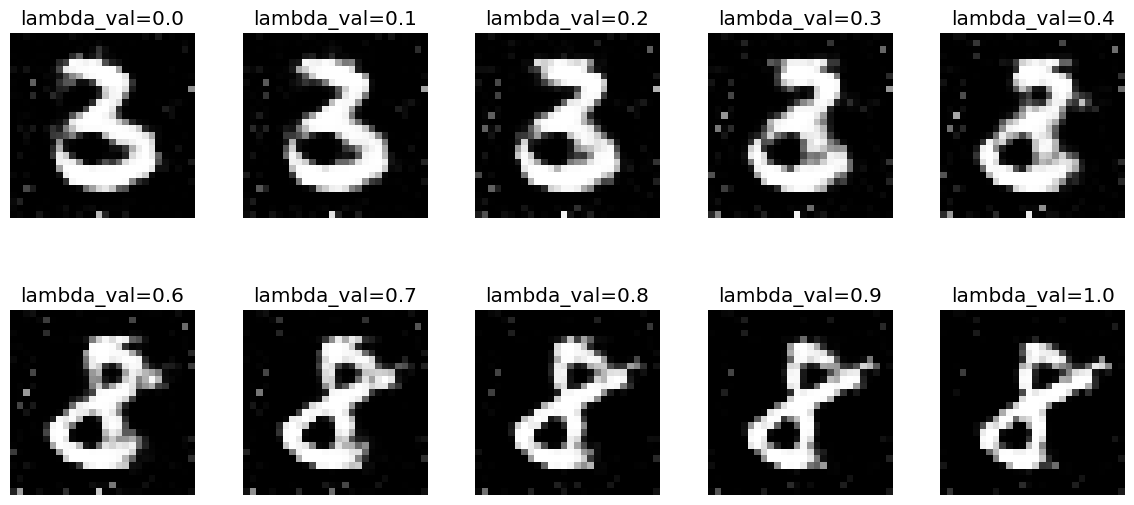

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()

def interpolation(lambda1, model, latent_1, latent_2):

    with torch.no_grad():

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_latent = inter_latent.to(device)
        inter_image = model(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image
    
# sample two latent vectors from the standard normal distribution
latent_1 = torch.randn(1, latent_dims, device=device)
latent_2 = torch.randn(1, latent_dims, device=device)

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image = interpolation(float(l), generator, latent_1, latent_2)
   
    inter_image = to_img(inter_image)
    
    image = inter_image.numpy()
   
    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
    axs[ind].axis('off')
    
plt.show() 

## 4. InfoGAN

### Hyperparameters


In [4]:
latent_dims = 50 # dimension of noize vector (z)
num_epochs = 40
batch_size = 64
learning_rate_disc = 1e-5
learning_rate_gen = 1e-3
use_gpu = True

### MNIST Data Loading

MNIST images show digits from 0-9 in 28x28 grayscale images. We scale to 64x64 so we can have a deeper architecture with more down-sampling steps. The images are normalized and centerd around 0, which gives a slight performance boost during training. We create both a training set and a test set.



In [5]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [6]:
def count_param(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### 64x64 InfoGAN Architecture


In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(latent_dims + 12, 1024, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(1024)
        self.deconv2 = nn.ConvTranspose2d(1024, 256, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 1, 4, 2, 1)

    def forward(self, input):
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = torch.tanh(self.deconv5(x))

        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 4, 2, 1)
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 1024, 8, 1, 0)
        self.conv4_bn = nn.BatchNorm2d(1024)

    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.1)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.1)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.1)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.1)

        return x

class DHead(nn.Module):
    def __init__(self):
        super(DHead, self).__init__()
        self.conv = nn.Conv2d(1024, 1, 1, 1, 0)

    def forward(self, input):
        return torch.sigmoid(self.conv(input))

class QHead(nn.Module):
    def __init__(self):
        super(QHead, self).__init__()
        self.conv1 = nn.Conv2d(1024, 64, 1, 1, 0)
        self.conv1_bn = nn.BatchNorm2d(64)

        self.conv_discrete = nn.Conv2d(64, 10, 1) # 10 discrete units (c1)
        self.conv_mean = nn.Conv2d(64, 2, 1) # mean of Gaussian for continuous codes (c2, c3)
        self.conv_stdev = nn.Conv2d(64, 2, 1) # standard deviation of Gaussian for continuous codes (c2, c3)

    def forward(self, input):
        x = F.leaky_relu(self.conv1_bn(self.conv1(input)), 0.1)

        discrete_values = self.conv_discrete(x).squeeze()
        mean = self.conv_mean(x).squeeze()
        exp_stdev = torch.exp(self.conv_stdev(x).squeeze())

        return discrete_values, mean, exp_stdev
    
generator = Generator()
discriminator = Discriminator()
discriminator_head = DHead()
recognition_head = QHead()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
print(device)

generator = generator.to(device)
discriminator = discriminator.to(device)
discriminator_head = discriminator_head.to(device)
recognition_head = recognition_head.to(device)

num_params_gen = count_param(generator)
num_params_disc = count_param(discriminator) + count_param(discriminator_head)
num_params_Q = count_param(discriminator) + count_param(recognition_head)
print('Number of parameters for generator: {:,} and discriminator: {:,} and Q: {:,}'.format(num_params_gen, num_params_disc, num_params_Q))

cpu
Number of parameters for generator: 5,870,913 and discriminator: 17,438,913 and Q: 17,504,526


In [ ]:
# load and train

generator = Generator()
discriminator = Discriminator()
discriminator_head = DHead()
recognition_head = QHead()

generator.load_state_dict(torch.load('/content/drive/MyDrive/data303/gan/models/infogan-generator-ver3-60epoch.pth', map_location=device))
discriminator.load_state_dict(torch.load('/content/drive/MyDrive/data303/gan/models/infogan-discriminator-ver3-60epoch.pth', map_location=device))
discriminator_head.load_state_dict(torch.load('/content/drive/MyDrive/data303/gan/models/infogan-DHead-ver3-60epoch.pth', map_location=device))
recognition_head.load_state_dict(torch.load('/content/drive/MyDrive/data303/gan/models/infogan-QHead-ver3-60epoch.pth', map_location=device))

generator = generator.to(device)
discriminator = discriminator.to(device)
discriminator_head = discriminator_head.to(device)
recognition_head = recognition_head.to(device)

print(device)

cuda:0


In [ ]:
# GAN training can be unstable. In this case, the strong momentum
# for the gradient prevents convergence. One possible explanation is that the
# strong momentum does not allow the two players in the adversarial game to react
# to each other quickly enough. Decreasing beta1 (the exponential decay for the
# gradient moving average in [0,1], lower is faster decay) from the default 0.9
# to 0.5 allows for quicker reactions.
gen_optimizer = torch.optim.Adam(params=[{'params': generator.parameters()}, {'params': recognition_head.parameters()}], lr=learning_rate_gen, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(params=[{'params': discriminator.parameters()}, {'params': discriminator_head.parameters()}], lr=learning_rate_disc, betas=(0.5, 0.999))

# set to training mode
generator.train()
discriminator.train()

gen_loss_avg = []
disc_loss_avg = []
gen_images = [] # to store images generated by the generator by epoch

num_grid = 10

gen_latent = torch.randn(100, latent_dims, 1, 1, device=device)

# creating c1
idx = np.arange(10).repeat(10)
c1 = torch.zeros(100, 1, 10, device=device)
c1[torch.arange(0, 100), 0, idx] = 1.0
c1 = c1.view(100, -1, 1, 1)
print(c1.shape)

gen_latent = torch.cat((gen_latent, c1), dim=1)

# creating c2 and c3 ~ Unif(-1,1)
c2 = torch.rand(100, 1, 1, 1, device=device) * 2 - 1
c3 = torch.rand(100, 1, 1, 1, device=device) * 2 - 1

print(c2.shape, c3.shape)

gen_latent = torch.cat((gen_latent, c2), dim=1)
gen_latent = torch.cat((gen_latent, c3), dim=1)

print(gen_latent.shape)ㅋ

torch.Size([100, 10, 1, 1])
torch.Size([100, 1, 1, 1]) torch.Size([100, 1, 1, 1])
torch.Size([100, 62, 1, 1])


In [ ]:
print('Training ...')

for epoch in range(num_epochs):

    gen_loss_avg.append(0)
    disc_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in train_dataloader:
        
        # get dataset image and create real and fake labels for use in the loss
        image_batch = image_batch.to(device)
        batch_size = image_batch.size(0)

        label_real = torch.ones(batch_size, device=device)
        label_fake = torch.zeros(batch_size, device=device)

        # generate a batch of images from samples of the latent prior
        latent = torch.randn(batch_size, latent_dims, 1, 1, device=device) # z vector

        # c1 vector
        c1 = torch.zeros(batch_size, 1, 10, device=device)
        idx = np.random.randint(10, size=batch_size)
        c1[torch.arange(0, batch_size), 0, idx] = 1.0
        c1 = c1.view(batch_size, -1, 1, 1)
        latent = torch.cat((latent, c1), dim=1)

        # c2/c3 vector
        c2 = torch.rand(batch_size, 1, 1, 1, device=device) * 2 - 1
        latent = torch.cat((latent, c2), dim=1)

        c3 = torch.rand(batch_size, 1, 1, 1, device=device) * 2 - 1
        latent = torch.cat((latent, c3), dim=1)
        
        fake_image_batch = generator(latent)

        # train discriminator to correctly classify real and fake
        # (detach the computation graph of the generator and the discriminator,
        # so that gradients are not backpropagated into the generator)
        real_pred = discriminator_head(discriminator(image_batch)).squeeze() 
        fake_pred = discriminator_head(discriminator(fake_image_batch.detach())).squeeze() 
        disc_loss = F.binary_cross_entropy(real_pred, label_real) + F.binary_cross_entropy(fake_pred, label_fake)
        
        disc_optimizer.zero_grad()
        disc_loss.backward()
        disc_optimizer.step()
        
        # train generator to output an image that is classified as real

        discriminator_output = discriminator(fake_image_batch)
        fake_pred = discriminator_head(discriminator_output).squeeze() 

        # train recognition network (Q)
        logits, mean, exp_var = recognition_head(discriminator_output)

        target = torch.LongTensor(idx).to(device)
        discrete_loss_func = nn.CrossEntropyLoss()
        discrete_loss = discrete_loss_func(logits[:, 0:10], target)

        continuous_loss_func = nn.GaussianNLLLoss()
        continuous_loss = continuous_loss_func(latent[:, (latent_dims + 10):].view(-1, 2), mean, exp_var) * 0.1

        gen_loss = F.binary_cross_entropy(fake_pred, label_real) + discrete_loss + continuous_loss
        
        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()
        
        gen_loss_avg[-1] += gen_loss.item()
        disc_loss_avg[-1] += disc_loss.item()
        num_batches += 1
            
    # create the final fake image for the epoch
    generated_img = generator(gen_latent).cpu().detach()
    generated_img = make_grid(generated_img, nrow = num_grid)
    save_image(generated_img, f"/content/drive/MyDrive/data303/gan/outputs/infogan_genimg_ver7_{epoch}.png")
    gen_images.append(generated_img)

    gen_loss_avg[-1] /= num_batches
    disc_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average loss generator vs. discrim.: %f vs. %f' %
          (epoch+1, num_epochs, gen_loss_avg[-1], disc_loss_avg[-1]))

Training ...
Epoch [1 / 40] average loss generator vs. discrim.: 2.111353 vs. 0.440463
Epoch [2 / 40] average loss generator vs. discrim.: 2.126597 vs. 0.435241
Epoch [3 / 40] average loss generator vs. discrim.: 2.159367 vs. 0.425106
Epoch [4 / 40] average loss generator vs. discrim.: 2.188098 vs. 0.419951
Epoch [5 / 40] average loss generator vs. discrim.: 2.210781 vs. 0.410311
Epoch [6 / 40] average loss generator vs. discrim.: 2.230894 vs. 0.406794
Epoch [7 / 40] average loss generator vs. discrim.: 2.267204 vs. 0.396216
Epoch [8 / 40] average loss generator vs. discrim.: 2.302849 vs. 0.390339
Epoch [9 / 40] average loss generator vs. discrim.: 2.319696 vs. 0.385380
Epoch [10 / 40] average loss generator vs. discrim.: 2.343823 vs. 0.380590
Epoch [11 / 40] average loss generator vs. discrim.: 2.378083 vs. 0.375809
Epoch [12 / 40] average loss generator vs. discrim.: 2.396416 vs. 0.368746
Epoch [13 / 40] average loss generator vs. discrim.: 2.418866 vs. 0.369163
Epoch [14 / 40] avera

In [ ]:
to_pil_image = transforms.ToPILImage()
imgs = [np.array(to_pil_image(img)) for img in gen_images]
imageio.mimwrite(f'/content/drive/MyDrive/data303/gan/outputs/infogan_genimg_ver7.gif', imgs, duration=0.5)

In [ ]:
torch.save(generator.state_dict(), f'/content/drive/MyDrive/data303/gan/models/infogan-generator-ver7.pth')
torch.save(discriminator.state_dict(),f'/content/drive/MyDrive/data303/gan/models/infogan-discriminator-ver7.pth')
torch.save(discriminator_head.state_dict(), f'/content/drive/MyDrive/data303/gan/models/infogan-DHead-ver7.pth')
torch.save(recognition_head.state_dict(),f'/content/drive/MyDrive/data303/gan/models/infogan-QHead-ver7.pth')

### InfoGan Figure Reproduction

In [8]:
device = torch.device("cpu")

generator = Generator()
generator.load_state_dict(torch.load('/content/drive/MyDrive/data303/gan/models/infogan-generator-ver7.pth', map_location=torch.device('cpu')))
generator = generator.to(device)

generator.eval()

Generator(
  (deconv1): ConvTranspose2d(62, 1024, kernel_size=(4, 4), stride=(1, 1))
  (deconv1_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(1024, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv4_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv5): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

torch.Size([50, 50, 1, 1])
torch.Size([50, 10, 1, 1])
torch.Size([50, 2, 1, 1])
torch.Size([50, 62, 1, 1])
torch.float32


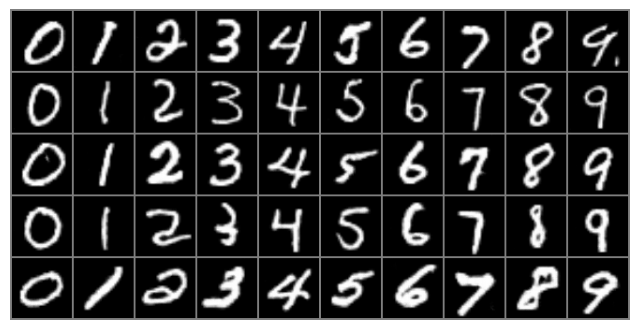

In [10]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

with torch.no_grad():

    # figure (a) : changing c1

    latent = torch.randn(50, latent_dims, 1, 1, device=device)
    print(latent.shape)

    idx = np.tile(np.array([7, 2, 6, 1, 9, 5, 3, 4, 0, 8]), 5)
    c1 = torch.zeros(50, 1, 10, device=device)
    c1[torch.arange(0, 50), 0, idx] = 1.0
    c1 = c1.view(50, -1, 1, 1)
    print(c1.shape)

    latent = torch.cat((latent, c1), dim=1)

    # same c2 and c3 for a row
    c2_c3 = np.repeat(torch.rand(5, 2, 1, 1, device=device) * 2 - 1, 10, axis = 0) 
    print(c2_c3.shape)

    latent = torch.cat((latent, c2_c3), dim=1)
    print(latent.shape)
    print(latent.dtype)

    fake_image_batch = generator(latent).cpu()

    fig, ax = plt.subplots(figsize=(8, 8))
    show_image(make_grid(fake_image_batch.data[:50], 10))
    ax.axis('off')
    plt.show()

torch.Size([50, 50, 1, 1])
torch.Size([50, 10, 1, 1])
torch.Size([50, 1, 1, 1])
tensor([[ 2.0000,  1.5556,  1.1111,  0.6667,  0.2222, -0.2222, -0.6667, -1.1111,
         -1.5556, -2.0000],
        [ 2.0000,  1.5556,  1.1111,  0.6667,  0.2222, -0.2222, -0.6667, -1.1111,
         -1.5556, -2.0000],
        [ 2.0000,  1.5556,  1.1111,  0.6667,  0.2222, -0.2222, -0.6667, -1.1111,
         -1.5556, -2.0000],
        [ 2.0000,  1.5556,  1.1111,  0.6667,  0.2222, -0.2222, -0.6667, -1.1111,
         -1.5556, -2.0000],
        [ 2.0000,  1.5556,  1.1111,  0.6667,  0.2222, -0.2222, -0.6667, -1.1111,
         -1.5556, -2.0000]])
torch.Size([50, 1, 1, 1])
tensor([[ 0.5575,  0.5575,  0.5575,  0.5575,  0.5575,  0.5575,  0.5575,  0.5575,
          0.5575,  0.5575],
        [ 0.6564,  0.6564,  0.6564,  0.6564,  0.6564,  0.6564,  0.6564,  0.6564,
          0.6564,  0.6564],
        [ 0.2950,  0.2950,  0.2950,  0.2950,  0.2950,  0.2950,  0.2950,  0.2950,
          0.2950,  0.2950],
        [-0.4196, -0.

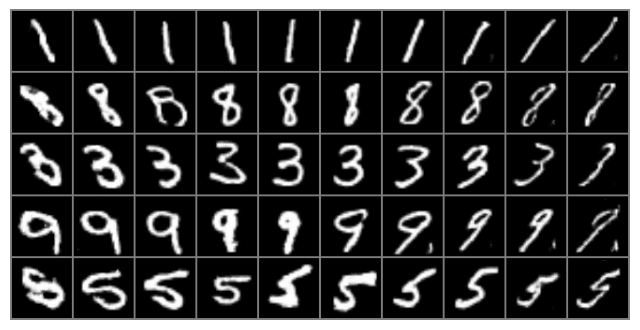

In [17]:
with torch.no_grad():

    # figure (c)

    latent = torch.randn(50, latent_dims, 1, 1, device=device)
    print(latent.shape)

    idx = np.repeat(np.array([2, 0, 1, 8, 5]), 10)
    c1 = torch.zeros(50, 1, 10, device=device)
    c1[torch.arange(0, 50), 0, idx] = 1.0
    c1 = c1.view(50, -1, 1, 1)
    print(c1.shape)

    latent = torch.cat((latent, c1), dim=1)

    # changing c2 in (-1, 1) / (-2, 2)
    # same c3 ~ Unif(-1, 1) for a row

    c2 = np.tile(np.linspace(2, -2, 10), 5) 
    c2 = c2.reshape(50, 1, 1, 1).astype(np.float32)
    c2 = torch.tensor(c2, device=device)

    print(c2.shape)
    print(c2.view(5, 10))

    latent = torch.cat((latent, c2), dim=1)

    c3 = np.repeat(torch.rand(5, 1, 1, 1, device=device) * 2 - 1, 10, axis = 0) 
    print(c3.shape)
    print(c3.view(5, 10))

    latent = torch.cat((latent, c3), dim=1)
    print(latent.shape)

    fake_image_batch = generator(latent).cpu()

    fig, ax = plt.subplots(figsize=(8, 8))
    show_image(make_grid(fake_image_batch.data[:50], 10))
    ax.axis('off')
    plt.show()

torch.Size([50, 50, 1, 1])
[2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 8 8 8 8 8 8 8
 8 8 8 5 5 5 5 5 5 5 5 5 5]
torch.Size([50, 10, 1, 1])
torch.Size([50, 1, 1, 1])
tensor([[ 0.1929,  0.1929,  0.1929,  0.1929,  0.1929,  0.1929,  0.1929,  0.1929,
          0.1929,  0.1929],
        [-0.7791, -0.7791, -0.7791, -0.7791, -0.7791, -0.7791, -0.7791, -0.7791,
         -0.7791, -0.7791],
        [-0.9322, -0.9322, -0.9322, -0.9322, -0.9322, -0.9322, -0.9322, -0.9322,
         -0.9322, -0.9322],
        [ 0.1316,  0.1316,  0.1316,  0.1316,  0.1316,  0.1316,  0.1316,  0.1316,
          0.1316,  0.1316],
        [-0.6132, -0.6132, -0.6132, -0.6132, -0.6132, -0.6132, -0.6132, -0.6132,
         -0.6132, -0.6132]])
torch.Size([50, 1, 1, 1])
tensor([[ 2.0000,  1.5556,  1.1111,  0.6667,  0.2222, -0.2222, -0.6667, -1.1111,
         -1.5556, -2.0000],
        [ 2.0000,  1.5556,  1.1111,  0.6667,  0.2222, -0.2222, -0.6667, -1.1111,
         -1.5556, -2.0000],
        [ 2.0000,  1.5556, 

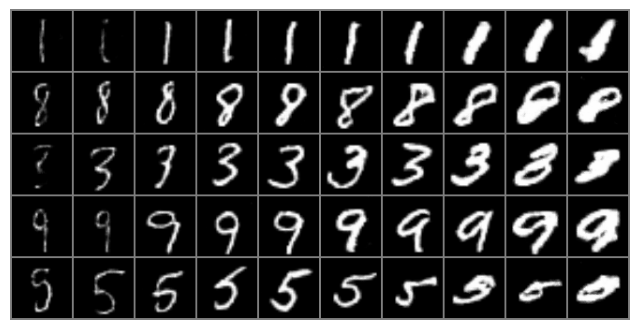

In [27]:
with torch.no_grad():

    # figure (d)

    latent = torch.randn(50, latent_dims, 1, 1, device=device)
    print(latent.shape)

    idx = np.repeat(np.array([2, 0, 1, 8, 5]), 10)
    print(idx)
    c1 = torch.zeros(50, 1, 10, device=device)
    c1[torch.arange(0, 50), 0, idx] = 1.0
    c1 = c1.view(50, -1, 1, 1)
    print(c1.shape)

    latent = torch.cat((latent, c1), dim=1)

    # changing c3 in (-1, 1) / (-2, 2)
    # same c2 ~ Unif(-1, 1) for a row

    c2 = np.repeat(torch.rand(5, 1, 1, 1, device=device) * 2 - 1, 10, axis = 0) 
    print(c2.shape)
    print(c2.view(5, 10))

    latent = torch.cat((latent, c2), dim=1)

    c3 = np.tile(np.linspace(2, -2, 10), 5) 
    c3 = c3.reshape(50, 1, 1, 1).astype(np.float32)
    c3 = torch.tensor(c3, device=device)

    print(c3.shape)
    print(c3.view(5, 10))

    latent = torch.cat((latent, c3), dim=1)
    print(latent.shape)

    fake_image_batch = generator(latent).cpu()

    fig, ax = plt.subplots(figsize=(8, 8))
    show_image(make_grid(fake_image_batch.data[:50], 10))
    ax.axis('off')
    plt.show()